用带反卷积层的卷子自编码器生成MNIST数据
===

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from jjzhk.progressbar import ProgressBar


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [2]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 456
learning_rate = 0.005
num_epochs = 10
batch_size = 128

Device: cuda:0


# 2.引入数据集

In [3]:
train_dataset = datasets.MNIST(root='/input', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='/input', 
                              train=False, 
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# 3.模型

In [4]:
class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        ### ENCODER
        
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1) 
        # 28x28x4 => 14x14x4                              
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(14-1) - 28 + 2) / 2 = 0
                                         padding=0)                                       
        # 14x14x4 => 14x14x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(14-1) - 14 + 3) / 2 = 1
                                      padding=1)                 
        # 14x14x8 => 7x7x8                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(7-1) - 14 + 2) / 2 = 0
                                         padding=0)
        
        ### DECODER
                                         
        # 7x7x8 => 15x15x4                          
        self.deconv_1 = torch.nn.ConvTranspose2d(in_channels=8,
                                                 out_channels=4,
                                                 kernel_size=(3, 3),
                                                 stride=(2, 2),
                                                 padding=0)
        
        # 15x15x4  => 31x31x1                           
        self.deconv_2 = torch.nn.ConvTranspose2d(in_channels=4,
                                                 out_channels=1,
                                                 kernel_size=(3, 3),
                                                 stride=(2, 2),
                                                 padding=0)
        
    def forward(self, x):
        
        ### ENCODER
        x = self.conv_1(x)
        x = F.leaky_relu(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = F.leaky_relu(x)
        x = self.pool_2(x)
        
        ### DECODER
        x = self.deconv_1(x)
        x = F.leaky_relu(x)
        x = self.deconv_2(x)
        x = F.leaky_relu(x)
        logits = x[:, :, 2:30, 2:30]
        probas = torch.sigmoid(logits)
        return logits, probas

    
torch.manual_seed(random_seed)
model = ConvolutionalAutoencoder()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# 4.训练

In [5]:
start_time = time.time()
bar = ProgressBar(num_epochs, len(train_loader), "Loss:%.3f")
for epoch in range(1, num_epochs+1):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.to(device)

        ### FORWARD AND BACK PROP
        logits, decoded = model(features)
        cost = F.binary_cross_entropy_with_logits(logits, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        bar.show(epoch, cost)

Epoch: 001/010 | Batch 000/468 | Cost: 0.7191
Epoch: 001/010 | Batch 050/468 | Cost: 0.6911
Epoch: 001/010 | Batch 100/468 | Cost: 0.5994
Epoch: 001/010 | Batch 150/468 | Cost: 0.3594
Epoch: 001/010 | Batch 200/468 | Cost: 0.3035
Epoch: 001/010 | Batch 250/468 | Cost: 0.2480
Epoch: 001/010 | Batch 300/468 | Cost: 0.2085
Epoch: 001/010 | Batch 350/468 | Cost: 0.1782
Epoch: 001/010 | Batch 400/468 | Cost: 0.1588
Epoch: 001/010 | Batch 450/468 | Cost: 0.1535
Time elapsed: 0.21 min
Epoch: 002/010 | Batch 000/468 | Cost: 0.1446
Epoch: 002/010 | Batch 050/468 | Cost: 0.1367
Epoch: 002/010 | Batch 100/468 | Cost: 0.1364
Epoch: 002/010 | Batch 150/468 | Cost: 0.1282
Epoch: 002/010 | Batch 200/468 | Cost: 0.1287
Epoch: 002/010 | Batch 250/468 | Cost: 0.1243
Epoch: 002/010 | Batch 300/468 | Cost: 0.1225
Epoch: 002/010 | Batch 350/468 | Cost: 0.1239
Epoch: 002/010 | Batch 400/468 | Cost: 0.1238
Epoch: 002/010 | Batch 450/468 | Cost: 0.1193
Time elapsed: 0.41 min
Epoch: 003/010 | Batch 000/468 | C

# 5.评估

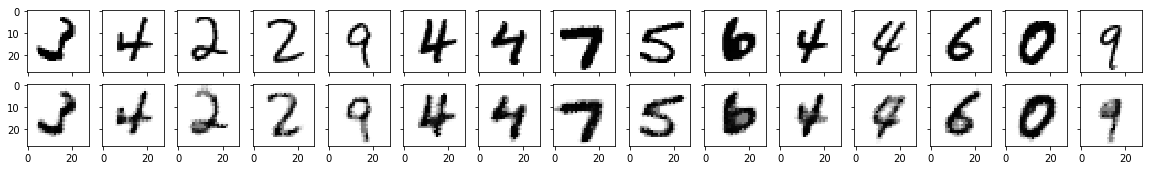

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')